## Phase I - Baseline Model Design and Review - HH

# Pull in Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib

2024-11-02 11:19:00.020144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 11:19:01.574348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 11:19:01.971748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 11:19:02.124783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 11:19:02.987926: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Specify the path to the zip file
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/hgz1prxm1kx14w5riy9du/ls_model_data_three.zip?rlkey=7cv22qxmmaeofr7jn6z7iayjy&dl=0?raw=1"

In [4]:
data_dir = tf.keras.utils.get_file('ls_model_data_three.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2000


In [6]:
## Review folders in incoming data / classes
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
print("Folders in the dataset directory:")
for folder in folders:
    print(folder.name)

Folders in the dataset directory:
landslide
non_landslide


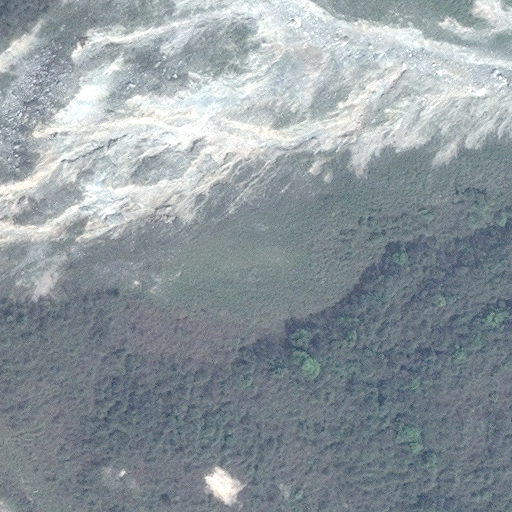

In [7]:
## Review an image
landslide_one = list(data_dir.glob('landslide/*'))
PIL.Image.open(str(landslide_one[0]))

## Set up Data Sets for model input

In [8]:
## Set Batch, Image size and number of Classes. 
batch_size = 32
img_height = 300
img_width = 300
land_class_num = len(folders)

In [9]:
## Set Training Set image set. 
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1500 files for training.


2024-11-02 11:20:02.605329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43482 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:63:00.0, compute capability: 8.6


In [10]:
## Setup Valiation set.
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 500 files for validation.


In [11]:
## Review class names based on dataset. 
class_names = train_dataset.class_names
print(class_names)

['landslide', 'non_landslide']


In [12]:
## Review sizes of images. 
counter_d = 0
for images, labels in train_dataset:
    if counter_d < 3:
        print(images.shape, labels.shape)
    counter_d += 1

(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)


2024-11-02 11:20:11.285943: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1500).prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

2024-11-02 11:20:14.067174: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


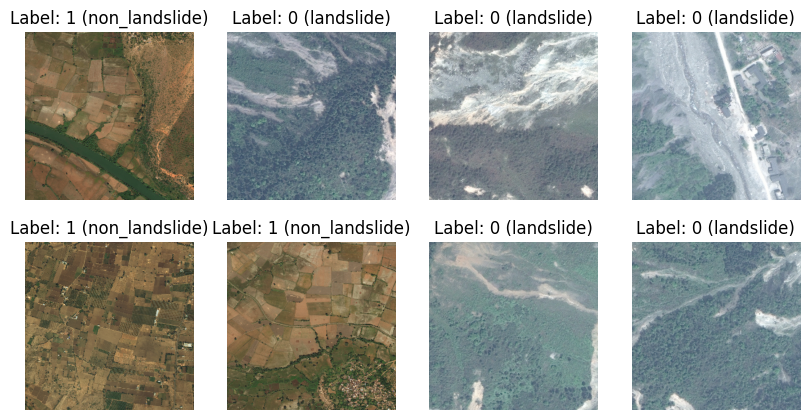

In [14]:
## Checking the Labels. 
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(8):  # Display first 6 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})")
        plt.axis("off")
plt.show()


<hr style="border:5px solid gray">

# Model

#### Plotting Helper

In [15]:
### Adding helper method for print option. 
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

<hr style="border:1px solid gray">

### Design Model Baseline

In [18]:
ls_model_ph_one = Sequential([
  # data_augmentation,  ## Data Augmentation
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Dropout(0.2),  ## Dropout
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),  ## Dropout
    layers.Dense(2, activation='softmax')   ### Use with SparseCategoricalCrossentropy
    # layers.Dense(1, activation='sigmoid')   ### Use with BinaryCrossentropy
])

**Compile**

In [19]:
## Setup model: Optmizer, Loss, Metrics
ls_model_ph_one.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.001),
            loss='sparse_categorical_crossentropy',
              # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                         # loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
ls_model_ph_one.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 300, 300, 16)   │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     2,803,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,814,354 (10.74 MB)

 Trainable params: 2,814,354 (10.74 MB)

 Non-trainable params: 0 (0.00 B)

#### **Fit**
ls_model_ph_one

In [22]:
## Fit Model
epochs = 10
landslide_history_one = ls_model_ph_one.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1730561190.731113  331808 service.cc:146] XLA service 0x7f3728004310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730561190.732777  331808 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-11-02 11:26:30.832782: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-02 11:26:30.928878: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904


 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5331 - loss: 0.6842

I0000 00:00:1730561193.857900  331808 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.5212 - loss: 0.6802 - val_accuracy: 0.4680 - val_loss: 0.6690
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5687 - loss: 0.6518 - val_accuracy: 0.9740 - val_loss: 0.6180
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8799 - loss: 0.5911 - val_accuracy: 0.9740 - val_loss: 0.5221
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9840 - loss: 0.4847 - val_accuracy: 0.9940 - val_loss: 0.3888
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9941 - loss: 0.3620 - val_accuracy: 0.9940 - val_loss: 0.2651
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9919 - loss: 0.2414 - val_accuracy: 0.9920 - val_loss: 0.1782
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9937 - loss: 0.1681 - val_accuracy: 0.9920 - val_loss: 0.1260
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9988 - loss: 0.1195 - val_accuracy: 0.9940 - val_loss: 0

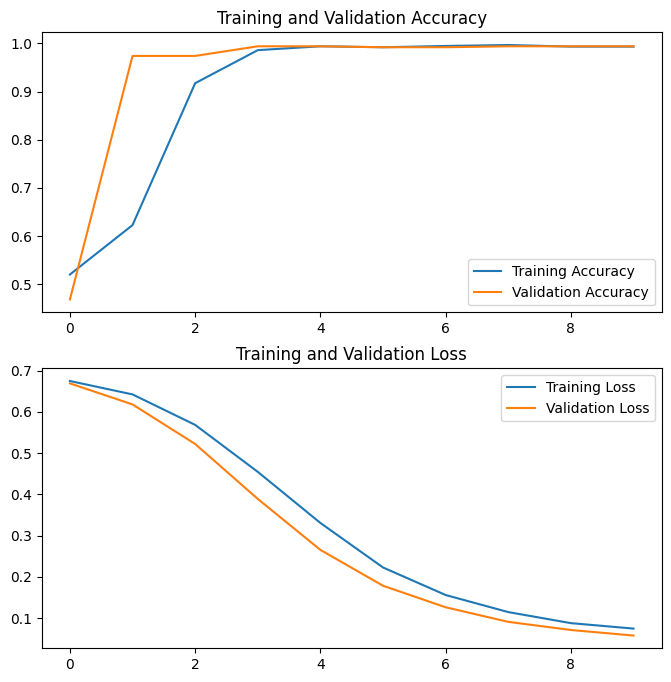

In [23]:
## Plot results
visualize_model_results(landslide_history_one)

<hr style="border:5px solid darkred">

# Design Model w/ Transfer Learning
Pre-Training with EfficientNet
- Strengths: EfficientNet models scale well in terms of parameters and efficiency, balancing accuracy with computational cost, which is especially useful for large datasets.
- Suitability: EfficientNet performs exceptionally well on high-resolution images, which is ideal for detecting fine details in satellite images.
- https://viso.ai/deep-learning/efficientnet/
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

**Setting up EfficientNet**
- Note - using B3 as this is set up for 300x300 images. 

In [32]:
## Import
from tensorflow.keras.applications import EfficientNetB3

In [70]:
# Setting up parameters for model. 
IMG_SIZE=300
learn_rate_land = .01  ## For optimizer.
print(land_class_num) ## Check class number AND use as argument below.

2


**Helper Functions**

In [71]:
## Helper Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(factor=0.1),
    # layers.RandomSaturation(.7, seed=516) ## Error
    layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.7, upper=1.5))
  ]
)

In [72]:
# Create the base model from the pre-trained model EfficientNetB3.
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ### Adding Augmentation
    inputs = data_augmentation(inputs)  ## Added Line
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate_land)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


#### **Fit**
landslide_model_ENB3

In [73]:
landslide_model_ENB3 = build_model(num_classes=land_class_num)

epochs = 30  # @param {type: "slider", min:8, max:80}
landslide_ENB3_hist = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset)


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 348ms/step - accuracy: 0.9336 - loss: 0.1667 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9982 - loss: 0.0037 - val_accuracy: 0.9940 - val_loss: 0.0136
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9985 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 6.0775e-04
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 6.4776e-04 - val_accuracy: 1.0000 - val_loss: 3.3467e-05
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 7.3706e-05 - val_accuracy: 1.0000 - val_loss: 1.6367e-05
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9987 - loss: 0.0097 - val_accuracy: 0.9980 - val_loss: 0.0100
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9969 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 6.1943e-04
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9989 - loss: 0.0138 

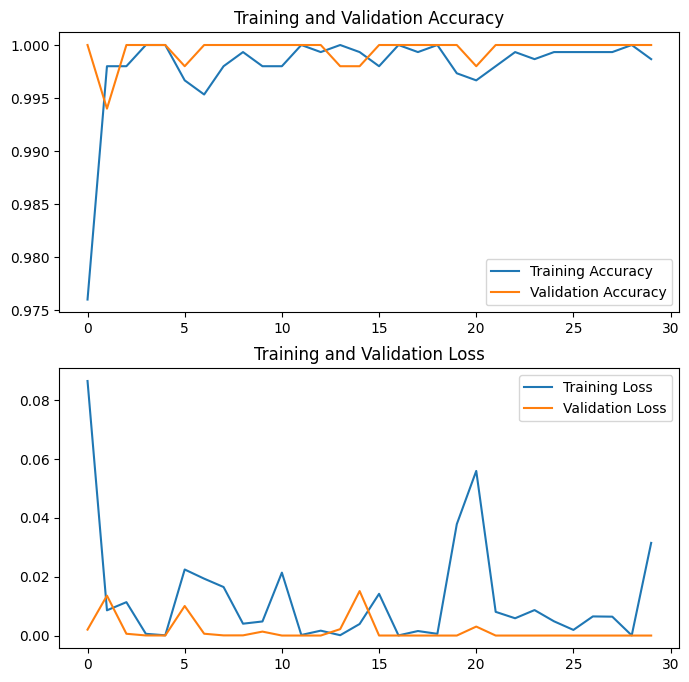

In [74]:
## Plot results
visualize_model_results(landslide_ENB3_hist)

<hr style="border:2px solid gray">

## Testing a single image.

#### Helper Functions

In [75]:
## Prediction Helper
def predict_landslide_image(image_path, model):
    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width) )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    # score = tf.nn.softmax(predictions[0])
    score = predictions[0]

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [76]:
## Resize and Printer Helper
def resize_show(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(300,300)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    plt.imshow(img)
    plt.axis('off')  # Optional: turn off the axis
    plt.show()

---

### Image One

In [56]:
## Load Image
landslide_img_one_url = "https://dl.dropboxusercontent.com/scl/fi/8hakddd7v7hqdfcggcs5p/NASA_GoogE_11454.jpg?rlkey=p2z6rlvd7gtovfiicgee8ocnq&dl=0?raw=1"
landslide_img_one_path = tf.keras.utils.get_file('NASA_GoogE_11454', origin=landslide_img_one_url)

1378448/1378448 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


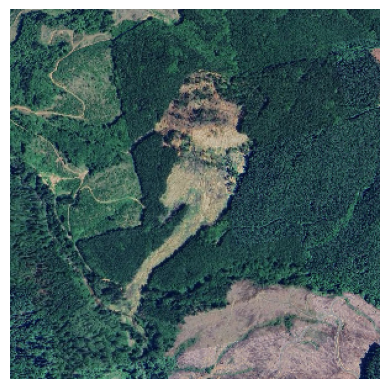

In [77]:
resize_show(landslide_img_one_path)

#### **Prediction Result**

In [78]:
predict_landslide_image(landslide_img_one_path, landslide_model_ENB3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
This image most likely belongs to landslide with a 100.00 percent confidence.


### Image Two

In [79]:
landslide_img_two_url = "https://dl.dropboxusercontent.com/scl/fi/jp4dauhe98kj34qg8dluy/NASA_GoogE_11454_NonSlide.jpg?rlkey=1gbfchwdwl54zmz2yc26xamr7&dl=0?raw=1"
landslide_img_two_path = tf.keras.utils.get_file('NASA_GoogE_13710_NonSlide', origin=landslide_img_two_url)

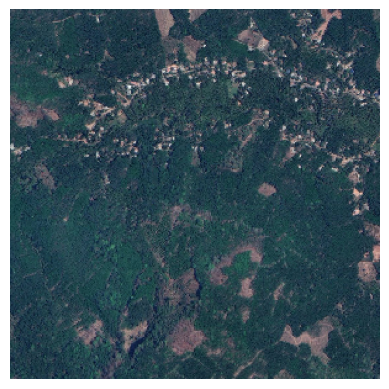

In [80]:
resize_show(landslide_img_two_path)

#### Predict

In [52]:
predict_landslide_image(landslide_img_two_path, landslide_model_ENB3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
This image most likely belongs to non_landslide with a 88.35 percent confidence.
